
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Виталий Радченко, Data scientist @ YouScan (@vradchenko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала

# <center> Домашнее задание № 5 (Демо).
## <center> Логистическая регрессия и случайный лес в задаче кредитного скоринга

[Веб-форма](https://docs.google.com/forms/d/1HASy2b_FLBHBCzzpG-TbnbB6gqhB-qwznQxU2vaoSgc/) для ответов.

#### Нашей главной задачей будет построение модели для задачи кредитного скоринга.

Но для разминки решите первое задание :)

**Задание 1.** В зале суда есть 5 присяжных, каждый из них по отдельности с вероятностью 70% может правильно определить, виновен подсудимый или нет. С какой вероятностью они все вместе вынесут правильный вердикт, если решение принимается большинством голосов?
- 70.00%
- 83.20%
- 83.70%
- 87.50%

Теперь перейдем непосредственно к машинному обучению.

#### Данные представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	      – Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0 

##### Независимые признаки
* age	                          –  Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	 – Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio  – 	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	 – Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate  – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse – 	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; тип -	integer
* NumberOfDependents  – Число человек в семье кредитозаёмщика; тип -	integer

### Если решение принимается большинством голосов, то нам нужно подсчитать вероятность с которой как минимум 3 из их голосов будут правильными. Будет считать по формуле Бернулли, где n=5, k = [3,4,5], вероятность получить k успехов = 0.7; Вероятности будут равны 0.3087, 0.36015 0.16807 и  соответственно. Прибавив эти вероятности получим ответ 0.83692, то есть ответ: 83.70%  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
from sklearn import tree
from scipy.special import softmax
import sklearn.preprocessing
import sklearn.metrics
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, confusion_matrix

In [2]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы 
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

In [3]:
## Считываем данные
data = pd.read_csv('credit_scoring_sample.csv', sep =';')
data.head()

SeriousDlqin2yrs  age  NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  \
0                 0   64                                     0     0.249908   
1                 0   58                                     0  3870.000000   
2                 0   41                                     0     0.456127   
3                 0   43                                     0     0.000190   
4                 1   49                                     0     0.271820   

   NumberOfTimes90DaysLate  NumberOfTime60-89DaysPastDueNotWorse  \
0                        0                                     0   
1                        0                                     0   
2                        0                                     0   
3                        0                                     0   
4                        0                                     0   

   MonthlyIncome  NumberOfDependents  
0         8158.0                 0.0  
1            NaN                 0.0  
2         6666.0                 0.0  
3        10500.0                 2.0  
4          400.0                 0.0

In [4]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

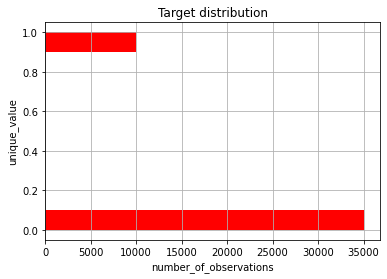

In [5]:
## Посмотрим на распределение классов в зависимой переменной

ax =data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [6]:

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names


['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [7]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table = delete_nan(data)


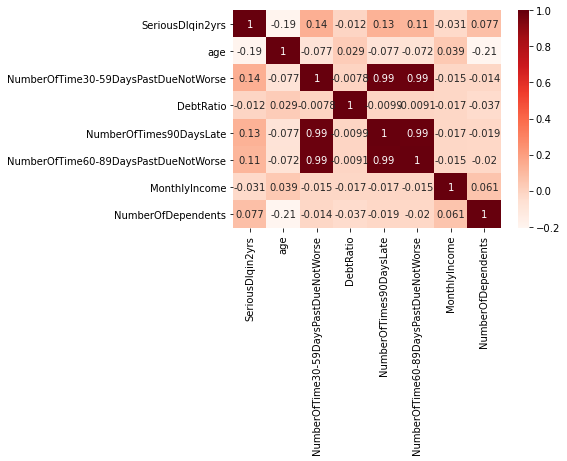

In [8]:
sns.heatmap(table.corr(), annot = True, cmap='Reds')

Смотрим Heatmap. Видим что признаки "NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse" коррелируют на 99%, Запомним это. Удалять их не станем, т.к. это призводит к уменьшению точности до 75%

In [9]:
X =table[independent_columns_names]
y = table['SeriousDlqin2yrs']
#X = X.drop(['NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse'], axis = 1)

In [10]:
#from imblearn.pipeline import make_pipeline
#from imblearn.over_sampling import *
#from imblearn.under_sampling import *
#smt = SMOTE(k_neighbors=5)
#X_resampled, Y_resampled = smt.fit_resample(X, y)
#sns.countplot(Y_resampled)

In [11]:
#X = X_resampled
#y = Y_resampled

# Бутстрэп

**Задание 2.** Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". Используйте пример из статьи, поставьте `np.random.seed(0)`, как это сделано в статье.

In [12]:
dt = data[(data['NumberOfTime30-59DaysPastDueNotWorse']>0) | (data['NumberOfTime60-89DaysPastDueNotWorse']>0)| (data['NumberOfTimes90DaysLate']>0) ]['age']
np.random.seed(0)
dtt = np.random.choice(dt, (1000,len(dt)))
print(f"Средний возраст должников - [{round(np.mean(dtt, axis = 1).min(), 2)} - {round(np.mean(dtt, axis = 1).max(), 2)}]")

Средний возраст должников - [47.04 - 47.76]


### Ответ: Средним возрастом клинетов которые просрочили платежи получился интвервал [47.04 - 47.76]

## Подбор параметров для модели логистической регрессии 

#### Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0  до 1.   Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight= 'balanced')
## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны, 
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть 
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

**Задание 3.**
Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра С?

In [14]:
clf = GridSearchCV(lr, {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}, return_train_score = True, cv = skf, scoring='roc_auc')
clf.fit(X, y)
df1 = pd.DataFrame(clf.cv_results_)
best_C = df1[df1['mean_test_score']==df1['mean_test_score'].max()]['param_C'][1]
print(f"Делаем Grid Search по параметру С. Лучшее значение - {best_C}, roc-auc - {round(df1['mean_test_score'].max()*100, 2)}%")

Делаем Grid Search по параметру С. Лучшее значение - 0.001, roc-auc - 80.89%


### Ответ : Лучшее значение С - 0.001

In [15]:
df1['mean_test_score'].max()

0.8089120626797153

**Задание 4.** 
Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) Сохраните точность лучшей модели, она вам приходится для следующих заданий

In [16]:
if df1[df1['mean_test_score']==df1['mean_test_score'].max()]['std_test_score'][1] < 0.05: 
    print("Yes")
else:
    print("No")

Yes


### Ответ: Можно

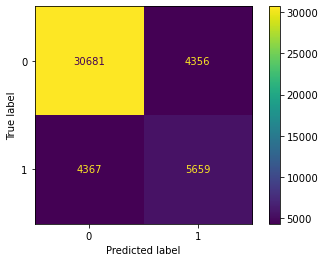

In [17]:
plot_confusion_matrix(clf.best_estimator_, X, y)

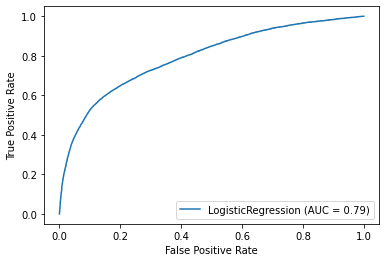

In [18]:
plot_roc_curve(clf.best_estimator_, X, y)

TrueNegative гораздо больше чем TruePositive. Скорее всего из-за того что данные несбалансированы, и данных класса "0" гораздо больше чем данных класса "1"

## Определение влияния признаков

**Задание 5.**
Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [19]:
coefs_abs = abs(sklearn.preprocessing.normalize(clf.best_estimator_.coef_))[0]
print(f"The most valuable feature: {X.columns[np.where(coefs_abs==coefs_abs.max())[0][0]]}")

The most valuable feature: NumberOfTime30-59DaysPastDueNotWorse


### Ответ: Самый важный признак - NumberOfTime30-59DaysPastDueNotWorse

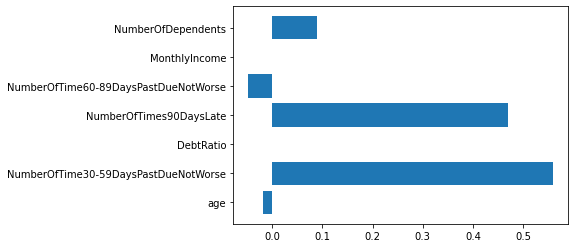

In [20]:
plt.barh(independent_columns_names, clf.best_estimator_.coef_[0])
plt.show()

In [21]:
np.round(clf.best_estimator_.coef_[0], 10)

array([-1.83037294e-02,  5.59124461e-01, -1.44770000e-05,  4.69219679e-01,
       -4.72042184e-02, -8.50540000e-06,  8.98504506e-02])

**Задание 6.** Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией [softmax](https://en.wikipedia.org/wiki/Softmax_function))

In [22]:
softmax(coefs_abs)[2]

0.10815918299424337

### Ответ: 10.8%

Помоему немного странно что DebtRatio Оказывает такое влияние на предсказание, так как в логистической регрессии его коэффициент очень мал.

**Задание 7.** 
Давайте посмотрим как можно интерпретировать влияние наших признаков. Для этого заного оценим логистическую регрессию в абсолютных величинах. После этого посчитайте во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков. (теоретический расчет можно посмотреть [здесь](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf))

In [23]:
lr = lr.fit(X, y)
prob = lr.predict(X).sum()
X1 = X
X1['age'] = X1['age']+20
lr = lr.fit(X, y)
prob/lr.predict(X).sum()

1.0503156686435815

### Ответ: уменьшатся в 0.95 раз

# Случайный лес

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами 
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                            random_state=42, oob_score=True, 
                            class_weight='balanced')
## Будем искать лучшие параметры среди следующего набора
parameters = {'max_features': [1, 2, 4], 
              'min_samples_leaf': [3, 5, 7, 9], 
              'max_depth': [5,10,15]
             }

**Задание 8.** На сколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

In [25]:
rf1 = GridSearchCV(estimator=rf, param_grid=parameters, return_train_score = True, cv = skf, scoring='roc_auc')
rf1.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, oob_score=True,
                                              random_state=42),
             param_grid={'max_depth': [5, 10, 15], 'max_features': [1, 2, 4],
                         'min_samples_leaf': [3, 5, 7, 9]},
             return_train_score=True, scoring='roc_auc')

In [26]:
df = pd.DataFrame(rf1.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
19       1.267824      0.006132         0.047817        0.001318   

   param_max_depth param_max_features param_min_samples_leaf  \
19              10                  2                      9   

                                               params  split0_test_score  \
19  {'max_depth': 10, 'max_features': 2, 'min_samp...           0.830914   

    split1_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
19           0.840678  ...         0.835733         0.00354                1   

    split0_train_score  split1_train_score  split2_train_score  \
19            0.860032              0.8585            0.859901   

    split3_train_score  split4_train_score  mean_train_score  std_train_score  
19             0.86052            0.858407          0.859472         0.000857  

[1 rows x 23 columns]

In [27]:
print(f"Точность рандомного леса выше на {round((df['mean_test_score'].max()-df1['mean_test_score'].max())*100, 2)}%")

Точность рандомного леса выше на 2.68%


### Ответ: На 2.68%

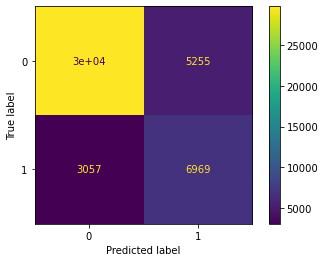

In [28]:
plot_confusion_matrix(rf1.best_estimator_, X, y)

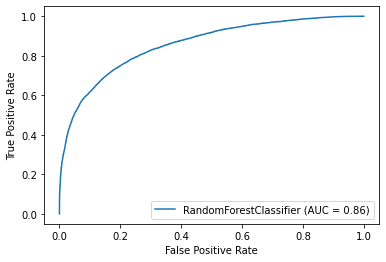

In [29]:
plot_roc_curve(rf1.best_estimator_, X, y)

**Задание 9.** Определите какой признак имеет самое слабое влияние.

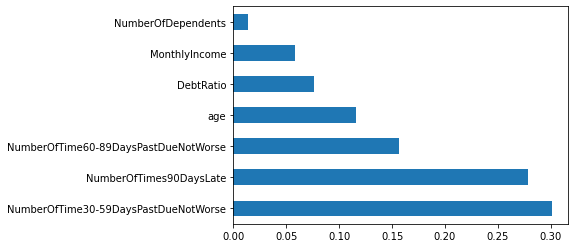

In [30]:
(pd.Series(rf1.best_estimator_.feature_importances_, index=X.columns)
   .nlargest(7)
   .plot(kind='barh'))

### Ответ: NumberOfDependents

** Задание 10.** Какое наиболее существенное примущество логистической регрессии перед случайным лесом для нашей бизнес-задачи?

- меньше тратится времени для тренировки модели;
- меньше параметров для перебора;
- интепретируемость признаков;
- линейные свойства алгоритма.

### Ответ: Меньше тратится времени для тренировки модели

# Бэггинг

In [31]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
parametersbag = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100]}

**Задание 11.** Следующая задача обучить бэггинг классификатор (`random_state`=42). В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не `GridSearchCV`, а `RandomizedSearchCV`. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для `RandomizedSearchCV`. Также не забудьте передать параметр валидации `cv` и `random_state=1`. Какая лучшая точность получилась?

In [32]:
lr = LogisticRegression(random_state=5, class_weight= 'balanced')
bc = BaggingClassifier(random_state=42, base_estimator = lr, n_estimators=100)
rs = RandomizedSearchCV(estimator=bc, param_distributions=parametersbag, return_train_score = True, cv = skf, scoring='roc_auc', random_state = 1, n_iter=20)

In [33]:
%%time
rs.fit(X,y)

Wall time: 16min 25s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
                   estimator=BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced',
                                                                                 random_state=5),
                                               n_estimators=100,
                                               random_state=42),
                   n_iter=20,
                   param_distributions={'base_estimator__C': [0.0001, 0.001,
                                                              0.01, 1, 10,
                                                              100],
                                        'max_features': [2, 3, 4],
                                        'max_samples': [0.5, 0.7, 0.9]},
                   random_state=1, return_train_score=True, scoring='roc_auc')

In [34]:
df2 = pd.DataFrame(rs.cv_results_)
df2[df2['mean_test_score']==df2['mean_test_score'].max()]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       6.440384      0.192848         0.015758        0.002779   

  param_max_samples param_max_features param_base_estimator__C  \
5               0.9                  2                     100   

                                              params  split0_test_score  \
5  {'max_samples': 0.9, 'max_features': 2, 'base_...           0.807955   

   split1_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
5           0.814288  ...         0.809933        0.004533                1   

   split0_train_score  split1_train_score  split2_train_score  \
5            0.808899             0.80891            0.812599   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
5            0.809813            0.809549          0.809954          0.00137  

[1 rows x 23 columns]

**Задача 12.** Дайте интерпретацию лучших параметров для бэггинга. Почему именно такие значения оказались лучшими?

- для бэггинга важно использовать как можно меньше признаков
- бэггинг лучше работает на небольших выборках
- меньше корреляция между одиночными моделями
- чем больше признаков, тем меньше теряется информации

### Ответ: бэггинг лучше работает на небольших выборках